<a href="https://colab.research.google.com/github/abiel2020/RIT_ML/blob/main/Final_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Define paths and parameters
DATA_DIR = "/content/drive/MyDrive/CSCI-335/train/images/"  # Directory containing the images
CSV_FILE = "/content/drive/MyDrive/CSCI-335/train/gt.csv"  # CSV file with keypoints
IMG_SIZE = 224  # Input size for MobileNetV2
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

In [ ]:
# Create dataset class
class BirdDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Print column information to understand the structure
        print("CSV columns:", self.data.columns.tolist())

        # Create a mapping of class IDs to indices
        # Since class_id is already numeric, we can use it directly
        self.classes = sorted(self.data['class_id'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        print(f"Number of classes: {len(self.classes)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])  # First column is filename
        image = Image.open(img_name).convert('RGB')

        # Get label from class_id column
        class_id = self.data.iloc[idx]['class_id']
        label = self.class_to_idx[class_id]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load and prepare the dataset
full_dataset = BirdDataset(CSV_FILE, DATA_DIR, transform=data_transforms['train'])
print(f"Total number of images: {len(full_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")


CSV columns: ['filename', 'class_id']
Number of classes: 50
Total number of images: 2500
Number of classes: 50


In [ ]:
# Split the dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [ ]:
# Create validation dataset with val transforms
class ValBirdDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        # If we're using the raw PIL image
        if isinstance(image, Image.Image) and self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Apply validation transforms to validation dataset
val_dataset = ValBirdDataset(val_dataset, transform=data_transforms['val'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Load pre-trained model
def create_model(num_classes):
    model = models.mobilenet_v2(pretrained=True)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last few layers
    for param in model.features[-3:].parameters():
        param.requires_grad = True

    # Modify the classifier
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features, num_classes)
    )

    return model
model = create_model(len(full_dataset.classes))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.features[-3:].parameters(), 'lr': LEARNING_RATE},
    {'params': model.classifier.parameters(), 'lr': LEARNING_RATE}
], weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, target_accuracy=0.85):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'top3_acc': [],
        'top5_acc': []
    }

    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        top3_corrects = 0
        top5_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                # Calculate top-k accuracy
                _, top3_preds = outputs.topk(3, 1, True, True)
                top3_preds = top3_preds.t()
                correct3 = top3_preds.eq(labels.view(1, -1).expand_as(top3_preds))
                top3_corrects += correct3.reshape(-1).float().sum(0)

                _, top5_preds = outputs.topk(5, 1, True, True)
                top5_preds = top5_preds.t()
                correct5 = top5_preds.eq(labels.view(1, -1).expand_as(top5_preds))
                top5_corrects += correct5.reshape(-1).float().sum(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)
        epoch_top3_acc = top3_corrects / len(val_loader.dataset)
        epoch_top5_acc = top5_corrects / len(val_loader.dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())
        history['top3_acc'].append(epoch_top3_acc.item())
        history['top5_acc'].append(epoch_top5_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        print(f'Top-3 Acc: {epoch_top3_acc:.4f} Top-5 Acc: {epoch_top5_acc:.4f}')

        # Update learning rate
        scheduler.step(epoch_val_acc)

        # Save best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), 'birds_model.pt')
            print(f"Saved model with accuracy: {best_acc:.4f}")

        # Check if we've reached target accuracy
        if epoch_val_acc >= target_accuracy:
            print(f"Reached target accuracy of {target_accuracy}. Stopping training.")
            break

    return model, history

In [ ]:
# Train the model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS)

Epoch 1/15
----------


100%|██████████| 63/63 [04:18<00:00,  4.11s/it]


Train Loss: 2.7049 Acc: 0.2930


100%|██████████| 16/16 [00:49<00:00,  3.11s/it]


Val Loss: 2.0213 Acc: 0.3940
Top-3 Acc: 0.6680 Top-5 Acc: 0.7660
Saved model with accuracy: 0.3940
Epoch 2/15
----------


100%|██████████| 63/63 [03:40<00:00,  3.50s/it]


Train Loss: 1.6458 Acc: 0.5130


100%|██████████| 16/16 [00:39<00:00,  2.48s/it]


Val Loss: 1.5745 Acc: 0.5360
Top-3 Acc: 0.7740 Top-5 Acc: 0.8580
Saved model with accuracy: 0.5360
Epoch 3/15
----------


100%|██████████| 63/63 [03:35<00:00,  3.42s/it]


Train Loss: 1.3987 Acc: 0.5655


100%|██████████| 16/16 [00:39<00:00,  2.47s/it]


Val Loss: 1.5162 Acc: 0.5240
Top-3 Acc: 0.7880 Top-5 Acc: 0.8880
Epoch 4/15
----------


100%|██████████| 63/63 [03:42<00:00,  3.53s/it]


Train Loss: 1.2985 Acc: 0.6010


100%|██████████| 16/16 [00:40<00:00,  2.55s/it]


Val Loss: 1.3524 Acc: 0.6100
Top-3 Acc: 0.7980 Top-5 Acc: 0.8560
Saved model with accuracy: 0.6100
Epoch 5/15
----------


100%|██████████| 63/63 [03:53<00:00,  3.71s/it]


Train Loss: 1.1414 Acc: 0.6555


100%|██████████| 16/16 [00:40<00:00,  2.53s/it]


Val Loss: 1.2999 Acc: 0.6120
Top-3 Acc: 0.8120 Top-5 Acc: 0.8840
Saved model with accuracy: 0.6120
Epoch 6/15
----------


100%|██████████| 63/63 [03:42<00:00,  3.54s/it]


Train Loss: 1.0811 Acc: 0.6715


100%|██████████| 16/16 [00:40<00:00,  2.51s/it]


Val Loss: 1.3859 Acc: 0.6040
Top-3 Acc: 0.8100 Top-5 Acc: 0.8680
Epoch 7/15
----------


100%|██████████| 63/63 [03:52<00:00,  3.68s/it]


Train Loss: 1.0503 Acc: 0.6730


100%|██████████| 16/16 [00:40<00:00,  2.52s/it]


Val Loss: 1.3718 Acc: 0.5820
Top-3 Acc: 0.8140 Top-5 Acc: 0.8720
Epoch 8/15
----------


100%|██████████| 63/63 [03:47<00:00,  3.62s/it]


Train Loss: 0.9217 Acc: 0.7145


100%|██████████| 16/16 [00:42<00:00,  2.64s/it]


Val Loss: 1.2989 Acc: 0.6300
Top-3 Acc: 0.8320 Top-5 Acc: 0.8780
Saved model with accuracy: 0.6300
Epoch 9/15
----------


100%|██████████| 63/63 [03:40<00:00,  3.50s/it]


Train Loss: 0.9440 Acc: 0.7180


100%|██████████| 16/16 [00:39<00:00,  2.49s/it]


Val Loss: 1.4247 Acc: 0.5880
Top-3 Acc: 0.7880 Top-5 Acc: 0.8680
Epoch 10/15
----------


100%|██████████| 63/63 [03:45<00:00,  3.59s/it]


Train Loss: 0.8589 Acc: 0.7320


100%|██████████| 16/16 [00:39<00:00,  2.48s/it]


Val Loss: 1.3464 Acc: 0.5880
Top-3 Acc: 0.8380 Top-5 Acc: 0.9120
Epoch 11/15
----------


100%|██████████| 63/63 [03:49<00:00,  3.65s/it]


Train Loss: 0.8738 Acc: 0.7290


100%|██████████| 16/16 [00:41<00:00,  2.57s/it]


Val Loss: 1.3563 Acc: 0.6020
Top-3 Acc: 0.8160 Top-5 Acc: 0.8860
Epoch 12/15
----------


100%|██████████| 63/63 [03:45<00:00,  3.59s/it]


Train Loss: 0.7495 Acc: 0.7865


100%|██████████| 16/16 [00:39<00:00,  2.45s/it]


Val Loss: 1.2818 Acc: 0.6280
Top-3 Acc: 0.8120 Top-5 Acc: 0.8680
Epoch 13/15
----------


100%|██████████| 63/63 [03:39<00:00,  3.48s/it]


Train Loss: 0.6419 Acc: 0.8070


100%|██████████| 16/16 [00:40<00:00,  2.54s/it]


Val Loss: 1.2089 Acc: 0.6460
Top-3 Acc: 0.8420 Top-5 Acc: 0.8920
Saved model with accuracy: 0.6460
Epoch 14/15
----------


100%|██████████| 63/63 [03:40<00:00,  3.50s/it]


Train Loss: 0.6521 Acc: 0.8125


100%|██████████| 16/16 [00:39<00:00,  2.46s/it]


Val Loss: 1.1753 Acc: 0.6460
Top-3 Acc: 0.8300 Top-5 Acc: 0.8800
Epoch 15/15
----------


100%|██████████| 63/63 [03:43<00:00,  3.55s/it]


Train Loss: 0.6157 Acc: 0.8280


100%|██████████| 16/16 [00:49<00:00,  3.09s/it]

Val Loss: 1.1582 Acc: 0.6460
Top-3 Acc: 0.8240 Top-5 Acc: 0.8840


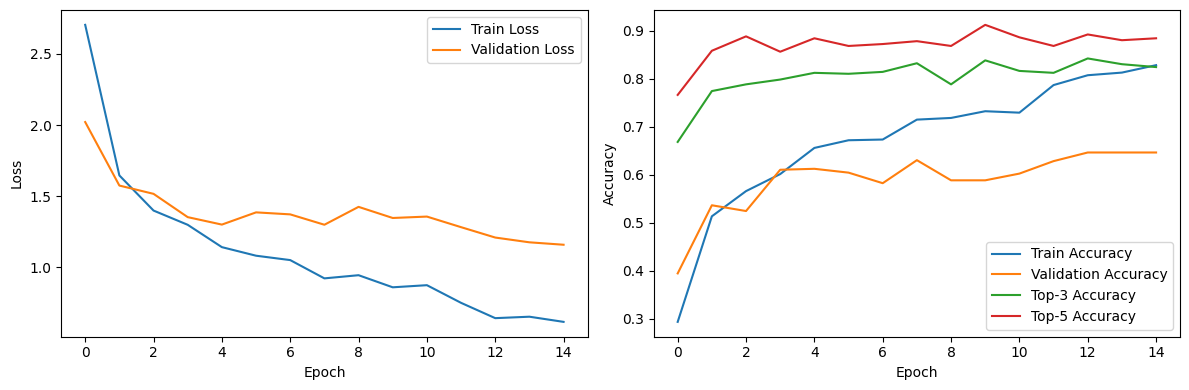

Best validation accuracy: 0.6460
Final top-5 accuracy: 0.8840


In [ ]:
# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.plot(history['top3_acc'], label='Top-3 Accuracy')
plt.plot(history['top5_acc'], label='Top-5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Print final stats
print(f"Best validation accuracy: {max(history['val_acc']):.4f}")
print(f"Final top-5 accuracy: {history['top5_acc'][-1]:.4f}")